#  **Malaria Detection**)

---



---






Malaria is a female anopheles’ mosquito-bite inflicted life-threatening disease which
is considered endemic in many parts of the world. This notebook focuses on improving
malaria detection from patches segmented from microscopic images of red blood cell
smears by introducing a deep convolutional neural network.



The dataset used in this study was taken from National Institute
of Health named [NIH Malaria Dataset](https://lhncbc.nlm.nih.gov/publication/pub9932).The dataset is published by Rajaraman S, Antani SK, Poostchi M, Silamut K, Hossain MA, Maude, RJ, Jaeger S, Thoma GR.


The dataset consists of 27,588 images belonging to two separate classes:


**Parasitized**: Implying that the region contains malaria.

**Uninfected**: Meaning there is no evidence of malaria in the region.
The number of images per class is equally distributed with 13,794 images per each respective class.




# Setup

In [0]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D
import os
import pandas as pd
from keras.callbacks import ModelCheckpoint,EarlyStopping
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_dir='/content/drive/My Drive/train'
test_dir='/content/drive/My Drive/test'
val_dir='/content/drive/My Drive/val'

# Define Required Functions

In [0]:
def create_model():
  #Conv Layers
  conv_base=VGG16(weights='imagenet',
               include_top=False,
               input_shape=(224,224,3))

  model=Sequential([(conv_base),
                  layers.Flatten(),
                  layers.Dense(2,activation='softmax')])
  #Set Untrainable layer
  print("Trainable_weight: ",len(model.trainable_weights))

  conv_base.trainable=True
  set_trainable=False
  for layer in conv_base.layers:
    if layer.name=='block5_conv1':
      set_trainable=True
    if set_trainable:
      layer.trainable=True
    else:
      layer.trainable=False
  
  print("After Frezing-")

  print("Trainable_weight: ",len(model.trainable_weights))
  return model

#Train function

def Train_model(model,train_generator,val_generator,batch_size,n_train,n_val):
  #Compile
  model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['acc'])
  #checkpoint
  filepath='/content/drive/My Drive/FaceRecognition/Malaria_weights-finetune-{epoch:02d}-{val_loss:.3f}.hdf5'
  checkpoint=ModelCheckpoint(filepath,monitor='val_loss',save_best_only=True,mode='min',verbose=1)
  callbacks_list=[checkpoint,EarlyStopping(monitor='val_loss',patience=6)]
 
  history=model.fit_generator(train_generator,
                            steps_per_epoch=n_train//batch_size,
                            epochs=50,
                            validation_data=val_generator,
                            validation_steps=n_val//batch_size,
                            callbacks=callbacks_list)
  return history

#Plot learningCurve function

def plot_LearningCurve(history):
    x=history.history['acc']
    y=history.history['val_acc']
    s=history.history['loss']
    t=history.history['val_loss']

    epochs=range(1,len(x)+1)
    plt.plot(epochs,x,label="Training_acc",linewidth=2)
    plt.plot(epochs,y,label="Val_acc",linewidth=2)
    plt.title('Training And Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    #plt.axis([0,22,0,1])
    plt.figure()
    plt.plot(epochs,s,label="Training_loss",linewidth=2)
    plt.plot(epochs,t,label="Val_loss",linewidth=2)
    plt.title('Training And Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    #plt.axis([0,22,0,1])
    plt.show()

#Generator function

def generator(directory,batch_size,class_mode,img_size):
  datagen=ImageDataGenerator(rescale=1./255)
  generator=datagen.flow_from_directory(directory,
                                        target_size=(img_size,img_size),
                                        batch_size=batch_size,
                                        class_mode=class_mode)
  return generator

#Generator with Augmentation

def generator_with_augmentation(directory,batch_size,class_mode,img_size):
  datagen=ImageDataGenerator(rescale=1./255,
                             rotation_range=50,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.25,
                             zoom_range=0.25,
                             horizontal_flip=True)
  generator=datagen.flow_from_directory(directory,
                                        target_size=(img_size,img_size),
                                        batch_size=batch_size,
                                        class_mode=class_mode)
  return generator

In [0]:
batch_size=64
class_mode='categorical'
img_size=224
n_train=16534
n_val=5512
n_test=5512
val_gen=generator(val_dir,batch_size,class_mode,img_size)
train_gen=generator_with_augmentation(train_dir,batch_size,class_mode,img_size)
test_gen=generator(test_dir,batch_size,class_mode,img_size)

Found 5512 images belonging to 2 classes.
Found 16534 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


# Classifier

In [0]:
new_model=create_model()
new_model.summary()

Trainable_weight:  28
After Frezing-
Trainable_weight:  8
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_12 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 50178     
Total params: 14,764,866
Trainable params: 7,129,602
Non-trainable params: 7,635,264
_________________________________________________________________


In [0]:
history=Train_model(new_model,train_gen,val_gen,batch_size,n_train,n_val)

Epoch 1/50
258/258 [==============================] - 223s 863ms/step - loss: 0.4011 - acc: 0.8582 - val_loss: 0.2353 - val_acc: 0.9320

Epoch 00001: val_loss improved from inf to 0.23529, saving model to /content/drive/My Drive/FaceRecognition/Malaria_weights-finetune-01-0.235.hdf5
Epoch 2/50
258/258 [==============================] - 220s 853ms/step - loss: 0.2342 - acc: 0.9210 - val_loss: 0.2190 - val_acc: 0.9205

Epoch 00002: val_loss improved from 0.23529 to 0.21900, saving model to /content/drive/My Drive/FaceRecognition/Malaria_weights-finetune-02-0.219.hdf5
Epoch 3/50
258/258 [==============================] - 221s 856ms/step - loss: 0.2232 - acc: 0.9256 - val_loss: 0.1924 - val_acc: 0.9330

Epoch 00003: val_loss improved from 0.21900 to 0.19244, saving model to /content/drive/My Drive/FaceRecognition/Malaria_weights-finetune-03-0.192.hdf5
Epoch 4/50
258/258 [==============================] - 216s 836ms/step - loss: 0.2252 - acc: 0.9263 - val_loss: 0.2152 - val_acc: 0.9198

Epo

In [0]:
print(plt.style.available)

['seaborn-paper', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-bright', 'seaborn-ticks', 'seaborn-talk', 'seaborn-colorblind', 'seaborn-darkgrid', 'fivethirtyeight', 'Solarize_Light2', 'seaborn-dark-palette', 'seaborn-deep', 'classic', '_classic_test', 'seaborn-notebook', 'bmh', 'seaborn-muted', 'fast', 'grayscale', 'seaborn-pastel', 'seaborn-poster', 'ggplot', 'seaborn', 'seaborn-dark', 'seaborn-whitegrid']


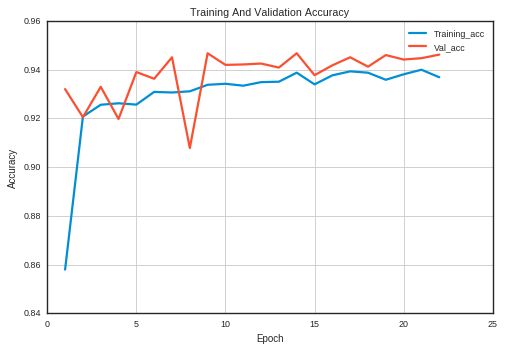

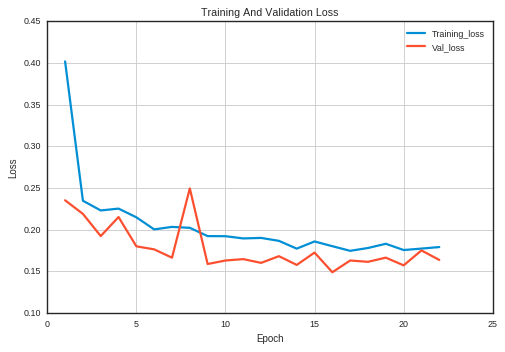

In [0]:
plot_LearningCurve(history)
plt.style.use('seaborn-bright')

# Testing

In [0]:
test_eval=new_model.evaluate_generator(test_gen,n_test//batch_size+1)
test_eval

[0.16398559071675095, 0.9531930333817126]

**Test Accuracy**: 95.32%

**Test Loss**: 0.164